In [1]:
print("hello")

hello


In [9]:
import gradio as gr
from constants import DATASET_PATH, LABELS, IMAGE_FOLDER, CLOUD_FOLDER
import pandas as pd
import subprocess
import os
import numpy as np
from PIL import Image
from pathlib import Path
import base64
from io import BytesIO
import requests
import json

# TEMP

In [ ]:
# Pick a few random images from each class (2 par classe soit 14 images)
df = pd.read_pickle(DATASET_PATH)
df_sampled = pd.concat([df[df["class"] == label].sample(2) for label in LABELS])
print(df_sampled.shape)

(14, 4)


In [ ]:
# Populate the image folders and add a constant path to this folder in constants.py
for i, row in df_sampled.iterrows():
    image_renamed = row["product_name"].replace("  ", "").strip().capitalize()
    df_sampled.at[i, "image_renamed"] = image_renamed
    subprocess.run(
        ["cp", IMAGE_FOLDER / row["image"], CLOUD_FOLDER / "images" / row["image"]]
    )

In [18]:
df_sampled.to_csv("sampled.csv", index=False)

# CONSTRUCTING

In [3]:
# Fonction lambda pour retourner un label bidon
def dummy_label(image):
    return str(np.random.choice(LABELS, 1)[0])

In [4]:
df = pd.read_csv("sampled.csv")

In [5]:
df.head()

,product_name,image,description,class,image_renamed
0,Boreal Plastic rectangular hair brush 633D,5ea8ddb8a5104c5d47c708e8a351e701.jpg,Specifications of Boreal Plastic rectangular h...,Baby Care,Boreal plastic rectangular hair brush 633d
1,Jacadi paris Baby Boy's Striped Casual Blue Shirt,4b500e244f11a45f5171bd3665413044.jpg,Key Features of Jacadi paris Baby Boy's Stripe...,Baby Care,Jacadi paris baby boy's striped casual blue shirt
2,RYTHMX FB NAIL POLISHES BLACK LIPSTICKS IMPORT...,5e84d36ad6db970548498829db8b15de.jpg,Specifications of RYTHMX FB NAIL POLISHES BLAC...,Beauty and Personal Care,Rythmx fb nail polishes black lipsticks import...
3,Anna Andre Paris Majesty Deodorant Combo Set,6e44d107ee32412243b19b0ed9b415f3.jpg,Flipkart.com: Buy Anna Andre Paris Majesty Deo...,Beauty and Personal Care,Anna andre paris majesty deodorant combo set
4,HP Compaq Presario CQ43 6 Cell Laptop Battery,9a8fa4fd6524ada03411b033a9daadc1.jpg,Buy HP Compaq Presario CQ43 6 Cell Laptop Batt...,Computers,Hp compaq presario cq43 6 cell laptop battery


In [6]:
files = os.listdir(CLOUD_FOLDER / "images")
filename2path = {filename: CLOUD_FOLDER / "images" / filename for filename in files}
id2filename = {
    df.loc[df["image"] == filename, "image_renamed"].values[0]: filename
    for filename in files
}

In [7]:
id2filename

{'Edimax br6524n n300 wireless router': '5c6b9db55291a68d99c4bb9a88266e27.jpg',
 'Home originals abstract, geometric double blanket multicolor': '841b14271aa4c29f291f600c9556145c.jpg',
 'Kosher kadhai 5 l': '7e4c1d31e279a700c6b8e66d820e8601.jpg',
 'Hp compaq presario cq43 6 cell laptop battery': '9a8fa4fd6524ada03411b033a9daadc1.jpg',
 'Sonata 8098ym01 analog watch- for women': '321f2ab0dd243778c87ac63ace6639f4.jpg',
 'Prithish believe in yourself double color ceramic mug': '02127f52e96fb72c66bf081d25104ef8.jpg',
 'Mavi 237mbb showpiece-15 cm': '7ee2e665b7de2e1cc29e3c65bde0c318.jpg',
 "Jacadi paris baby boy's striped casual blue shirt": '4b500e244f11a45f5171bd3665413044.jpg',
 'Lal haveli iron wall decorative musician showpiece-50.8 cm': 'be0e65c6d8c2cc8cb913b36aa4168cf0.jpg',
 'Fastrack 9912pp09 tees analog watch- for men, women': '8748b6cd9f03afc539f246c55e230502.jpg',
 'Boreal plastic rectangular hair brush 633d': '5ea8ddb8a5104c5d47c708e8a351e701.jpg',
 'Anna andre paris majesty de

In [8]:
def load_image(name: str) -> Path:
    """
    Load an image from the specified path.
    """
    filename = id2filename.get(name)
    filepath = filename2path.get(filename)
    return Image.open(filepath)

In [16]:
# Function to decode base64 string to image
def decode_base64_to_image(base64_str: str) -> Image.Image:
    image_bytes = base64.b64decode(base64_str)
    return Image.open(BytesIO(image_bytes))


# Function to convert image to base64 string
def img_to_base64(img):
    buffer = BytesIO()
    img.save(buffer, format="JPEG")
    return base64.b64encode(buffer.getvalue()).decode("utf-8")

In [17]:
img = load_image("Edimax br6524n n300 wireless router")

In [18]:
img.size

(662, 485)

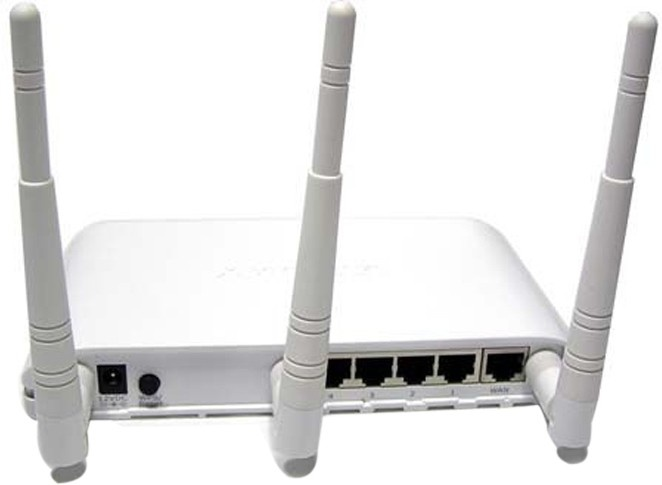

In [44]:
img.show()

In [19]:
img_b64 = img_to_base64(img)

In [26]:
type(img_b64)

str

In [ ]:
# Envoyer la requête POST de façon asynchrone
async with httpx.AsyncClient(timeout=120) as client:
    response = await client.post(f"http://localhost:8000/predict/", json=payload)
    response.raise_for_status()  # Lève une exception en cas d'erreur HTTP
    
try:
    results = response.json()
except json.JSONDecodeError:
    {"error": "La réponse de l'API n'est pas un JSON valide"}
    
if not results:
    {"error": "Réponse vide de l'API"}

In [31]:
# Create a request with the img_b64 as a payload to the API
def send_image_to_api(image_b64: str, endpoint: str) -> str:
    url = f"http://localhost:8000/{endpoint}/"
    headers = {"Content-Type": "application/json"}
    payload = json.dumps({"image": image_b64})
    response = requests.post(url, headers=headers, data=payload)
    return response.json()

In [45]:
response = send_image_to_api(img_b64, "predict")

In [46]:
response

{'predicted_label': 'Computers',
 'probabilities': {'Baby Care': 0.0,
  'Beauty and Personal Care': 0.0,
  'Computers': 0.99,
  'Home Decor & Festive Needs': 0.0,
  'Home Furnishing': 0.0,
  'Kitchen & Dining': 0.0,
  'Watches': 0.0}}

In [47]:
response = send_image_to_api(img_b64, "normalize")

In [48]:
img_nm = decode_base64_to_image(response["image_normalized"])
img_nm.size

(224, 224)

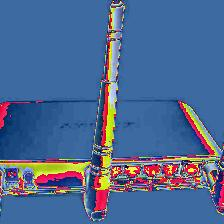

In [49]:
img_nm.show()

In [ ]:
# Gradio code pour l'interface utilisateur
with gr.Blocks() as demo:
    gr.Markdown("# Classification d'images")
    with gr.Row():
        dropdown = gr.Dropdown(
            label="Choisissez un produit dans la liste déroulante à afficher",
            choices=list(id2filename.keys()),  # Liste des labels
            value=list(id2filename.keys())[0],  # Valeur par défaut
        )

    with gr.Row():
        image_input = gr.Image(
            value=list(filename2path.values())[0],
            type="filepath",
            label="Image à classifier",
        )
        image_label = gr.Label(label="Catégorie prédite")

        # Charger l'exemple sélectionné
        dropdown.change(fn=load_image, inputs=dropdown, outputs=image_input)

    with gr.Row():
        # Bouton pour lancer la segmentation
        submit_btn = gr.Button("Classifier l'image")
        submit_btn.click(dummy_label, inputs=dropdown, outputs=[image_label])

demo.launch()

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


In [ ]:
# Gradio code pour l'interface utilisateur
with gr.Blocks() as demo:
    gr.Markdown("# Classification d'images")
    with gr.Row():
        dropdown = gr.Dropdown(
            label="Choisissez un produit dans la liste déroulante à afficher",
            choices=list(id2filename.keys()),  # Liste des labels
            value=list(id2filename.keys())[0],  # Valeur par défaut
        )

    # TODO : Tester les éléments de style CSS pour le côté accessibilité
    with gr.Row():
        image_input = gr.Image(
            value=list(filename2path.values())[0],
            type="filepath",
            label="Image à classifier",
            elem_id="image_input",  # ID pour le CSS
            elem_classes="image-input",  # Classes CSS pour le style
            show_label=True,  # Afficher le label
            interactive=True,  # Rendre l'image interactive
            tooltips="Cliquez pour charger une nouvelle image",  # Info-bulle
            visible=True,  # Rendre l'image visible
            height=224,  # TODO : Fixer la taille de l'image
            width=224,  # TODO : Fixer la taille de l'image
            elem_style={"border": "2px solid #ccc"},  # Style CSS pour l'image
        )
        image_label = gr.Label(label="Catégorie prédite")

        # Charger l'exemple sélectionné
        dropdown.change(fn=load_image, inputs=dropdown, outputs=image_input)

    with gr.Row():
        # Bouton pour lancer la segmentation
        submit_btn = gr.Button("Classifier l'image")
        submit_btn.click(dummy_label, inputs=dropdown, outputs=[image_label])

demo.launch()